In [2]:
import pandas as pd
from trader import Trader
from trader_filippo import Trader as TraderFilippo  # Importing the custom trader
from datamodel import *
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import List, Dict, Any

In [3]:
import io
def _process_data_(file):
    with open(file, 'r') as file:
        log_content = file.read()
    sections = log_content.split('Sandbox logs:')[1].split('Activities log:')
    sandbox_log =  sections[0].strip()
    activities_log = sections[1].split('Trade History:')[0]
    # sandbox_log_list = [json.loads(line) for line in sandbox_log.split('\n')]
    trade_history =  json.loads(sections[1].split('Trade History:')[1])
    # sandbox_log_df = pd.DataFrame(sandbox_log_list)
    market_data_df = pd.read_csv(io.StringIO(activities_log), sep=";", header=0)
    trade_history_df = pd.json_normalize(trade_history)
    return market_data_df, trade_history_df

In [4]:

data = pd.read_csv("b7e325da-1555-4de3-b99f-0f3017c74a62.csv",sep = ";")
imc_market_data, imc_trade_history = _process_data_("b7e325da-1555-4de3-b99f-0f3017c74a62.log")

In [5]:
imc_market_data

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,-1,0,RAINFOREST_RESIN,10002,1,9996.0,2.0,9995.0,29.0,10004,2,10005.0,29.0,NaN,NaN,10003.0,0.0
1,-1,0,KELP,2028,1,2026.0,2.0,2025.0,29.0,2029,31,NaN,NaN,NaN,NaN,2028.5,0.0
2,-1,100,KELP,2025,24,NaN,NaN,NaN,NaN,2028,2,2029.0,22.0,NaN,NaN,2026.5,0.0
3,-1,100,RAINFOREST_RESIN,9996,2,9995.0,22.0,NaN,NaN,10004,2,10005.0,22.0,NaN,NaN,10000.0,0.0
4,-1,200,RAINFOREST_RESIN,9995,20,NaN,NaN,NaN,NaN,10005,20,NaN,NaN,NaN,NaN,10000.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-1,199700,KELP,2020,27,NaN,NaN,NaN,NaN,2023,2,2024.0,25.0,NaN,NaN,2021.5,0.0
3996,-1,199800,RAINFOREST_RESIN,9995,21,NaN,NaN,NaN,NaN,10002,8,10005.0,21.0,NaN,NaN,9998.5,0.0
3997,-1,199800,KELP,2020,21,NaN,NaN,NaN,NaN,2023,21,NaN,NaN,NaN,NaN,2021.5,0.0
3998,-1,199900,KELP,2020,32,NaN,NaN,NaN,NaN,2022,7,2023.0,2.0,2024.0,30.0,2021.0,0.0


In [47]:
class Backtester:
    def __init__(self, trader, listings: Dict[str, Listing], position_limit: Dict[str, int], fair_marks, 
                 market_data: pd.DataFrame, trade_history: pd.DataFrame, file_name: str = None):
        self.trader = trader
        self.listings = listings
        self.market_data = market_data
        self.position_limit = position_limit
        self.fair_marks = fair_marks
        self.trade_history = trade_history.sort_values(by=['timestamp', 'symbol'])
        self.file_name = file_name

        self.observations = [Observation({}, {}) for _ in range(len(market_data))]

        self.current_position = {product: 0 for product in self.listings.keys()}
        self.pnl_history = []
        self.pnl = {product: 0 for product in self.listings.keys()}
        self.cash = {product: 0 for product in self.listings.keys()}
        self.trades = []
        self.sandbox_logs = []
        
    def run(self):
        traderData = ""
        
        timestamp_group_md = self.market_data.groupby('timestamp')
        timestamp_group_th = self.trade_history.groupby('timestamp')
        
        own_trades = defaultdict(list)
        market_trades = defaultdict(list)
        pnl_product = defaultdict(float)
        
        trade_history_dict = {}
        
        for timestamp, group in timestamp_group_th:
            trades = []
            for _, row in group.iterrows():
                symbol = row['symbol']
                price = row['price']
                quantity = row['quantity']
                buyer = row['buyer'] if pd.notnull(row['buyer']) else ""
                seller = row['seller'] if pd.notnull(row['seller']) else ""

                
                trade = Trade(symbol, int(price), int(quantity), buyer, seller, timestamp)
                
                trades.append(trade)
            trade_history_dict[timestamp] = trades
        
        
        for timestamp, group in timestamp_group_md:
            order_depths = self._construct_order_depths(group)
            order_depths_matching = self._construct_order_depths(group)
            order_depths_pnl = self._construct_order_depths(group)
            state = self._construct_trading_state(traderData, timestamp, self.listings, order_depths, 
                                 dict(own_trades), dict(market_trades), self.current_position, self.observations)
            orders, conversions, traderData = self.trader.run(state)
            products = group['product'].tolist()
            sandboxLog = ""
            trades_at_timestamp = trade_history_dict.get(timestamp, [])

            for product in products:
                new_trades = []
                for order in orders.get(product, []):
                    trades_done, sandboxLog = self._execute_order(timestamp, order, order_depths_matching, self.current_position, self.cash, trade_history_dict, sandboxLog)
                    new_trades.extend(trades_done)
                if len(new_trades) > 0:
                    own_trades[product] = new_trades
            self.sandbox_logs.append({"sandboxLog": sandboxLog, "lambdaLog": "", "timestamp": timestamp})

            trades_at_timestamp = trade_history_dict.get(timestamp, [])
            if trades_at_timestamp:
                for trade in trades_at_timestamp:
                    product = trade.symbol
                    market_trades[product].append(trade)
            else: 
                for product in products:
                    market_trades[product] = []

            
            for product in products:
                self._mark_pnl(self.cash, self.current_position, order_depths_pnl, self.pnl, product)
                self.pnl_history.append(self.pnl[product])
            self._add_trades(own_trades, market_trades)
        return self._log_trades(self.file_name)
    
    
    def _log_trades(self, filename: str = None):
        if filename is None:
            return 

        self.market_data['profit_and_loss'] = self.pnl_history

        output = ""
        output += "Sandbox logs:\n"
        for i in self.sandbox_logs:
            output += json.dumps(i, indent=2) + "\n"

        output += "\n\n\n\nActivities log:\n"
        market_data_csv = self.market_data.to_csv(index=False, sep=";")
        market_data_csv = market_data_csv.replace("\r\n", "\n")
        output += market_data_csv

        output += "\n\n\n\nTrade History:\n"
        output += json.dumps(self.trades, indent=2)

        with open(filename, 'w') as file:
            file.write(output)

            
    def _add_trades(self, own_trades: Dict[str, List[Trade]], market_trades: Dict[str, List[Trade]]):
        products = set(own_trades.keys()) | set(market_trades.keys())
        for product in products:
            self.trades.extend([self._trade_to_dict(trade) for trade in own_trades.get(product, [])])
        for product in products:
            self.trades.extend([self._trade_to_dict(trade) for trade in market_trades.get(product, [])])

    def _trade_to_dict(self, trade: Trade) -> dict[str, Any]:
        return {
            "timestamp": trade.timestamp,
            "buyer": trade.buyer,
            "seller": trade.seller,
            "symbol": trade.symbol,
            "currency": "SEASHELLS",
            "price": trade.price,
            "quantity": trade.quantity,
        }
        
    def _construct_trading_state(self, traderData, timestamp, listings, order_depths, 
                                 own_trades, market_trades, position, observations):
        state = TradingState(traderData, timestamp, listings, order_depths, 
                             own_trades, market_trades, position, observations)
        return state
 
        
    def _construct_order_depths(self, group):
        order_depths = {}
        for idx, row in group.iterrows():
            product = row['product']
            order_depth = OrderDepth()
            for i in range(1, 4):
                if f'bid_price_{i}' in row and f'bid_volume_{i}' in row:
                    bid_price = row[f'bid_price_{i}']
                    bid_volume = row[f'bid_volume_{i}']
                    if not pd.isna(bid_price) and not pd.isna(bid_volume):
                        order_depth.buy_orders[int(bid_price)] = int(bid_volume)
                if f'ask_price_{i}' in row and f'ask_volume_{i}' in row:
                    ask_price = row[f'ask_price_{i}']
                    ask_volume = row[f'ask_volume_{i}']
                    if not pd.isna(ask_price) and not pd.isna(ask_volume):
                        order_depth.sell_orders[int(ask_price)] = -int(ask_volume)
            order_depths[product] = order_depth
        return order_depths
    
        
        
    def _execute_buy_order(self, timestamp, order, order_depths, position, cash, trade_history_dict, sandboxLog):
        trades = []
        order_depth = order_depths[order.symbol]

        for price, volume in list(order_depth.sell_orders.items()):
            if price > order.price or order.quantity == 0:
                break

            trade_volume = min(abs(order.quantity), abs(volume))
            if abs(trade_volume + self.current_position[order.symbol]) <= int(self.position_limit[order.symbol]):
                trades.append(Trade(order.symbol, price, trade_volume, "SUBMISSION", "", timestamp))
                self.current_position[order.symbol] += trade_volume
                self.cash[order.symbol] -= price * trade_volume
                order_depth.sell_orders[price] += trade_volume
                order.quantity -= trade_volume
            else:
                sandboxLog += f"\nOrders for product {order.symbol} exceeded limit of {self.position_limit[order.symbol]} set"
                print(sandboxLog)
            

            if order_depth.sell_orders[price] == 0:
                del order_depth.sell_orders[price]
        
        trades_at_timestamp = trade_history_dict.get(timestamp, [])
        new_trades_at_timestamp = []
        for trade in trades_at_timestamp:
            if trade.symbol == order.symbol:
                if trade.price < order.price:
                    trade_volume = min(abs(order.quantity), abs(trade.quantity))
                    trades.append(Trade(order.symbol, order.price, trade_volume, "SUBMISSION", "", timestamp))
                    order.quantity -= trade_volume
                    self.current_position[order.symbol] += trade_volume
                    self.cash[order.symbol] -= order.price * trade_volume
                    if trade_volume == abs(trade.quantity):
                        continue
                    else:
                        new_quantity = trade.quantity - trade_volume
                        new_trades_at_timestamp.append(Trade(order.symbol, order.price, new_quantity, "", "", timestamp))
                        continue
            new_trades_at_timestamp.append(trade)  

        if len(new_trades_at_timestamp) > 0:
            trade_history_dict[timestamp] = new_trades_at_timestamp

        return trades, sandboxLog
        
        
        
    def _execute_sell_order(self, timestamp, order, order_depths, position, cash, trade_history_dict, sandboxLog):
        trades = []
        order_depth = order_depths[order.symbol]
        
        for price, volume in sorted(order_depth.buy_orders.items(), reverse=True):
            if price < order.price or order.quantity == 0:
                break

            trade_volume = min(abs(order.quantity), abs(volume))
            if abs(self.current_position[order.symbol] - trade_volume) <= int(self.position_limit[order.symbol]):
                trades.append(Trade(order.symbol, price, trade_volume, "", "SUBMISSION", timestamp))
                self.current_position[order.symbol] -= trade_volume
                self.cash[order.symbol] += price * abs(trade_volume)
                order_depth.buy_orders[price] -= abs(trade_volume)
                order.quantity += trade_volume
            else:
                sandboxLog += f"\nOrders for product {order.symbol} exceeded limit of {self.position_limit[order.symbol]} set"

            if order_depth.buy_orders[price] == 0:
                del order_depth.buy_orders[price]

        trades_at_timestamp = trade_history_dict.get(timestamp, [])
        new_trades_at_timestamp = []
        for trade in trades_at_timestamp:
            if trade.symbol == order.symbol:
                if trade.price > order.price:
                    trade_volume = min(abs(order.quantity), abs(trade.quantity))
                    trades.append(Trade(order.symbol, order.price, trade_volume, "", "SUBMISSION", timestamp))
                    order.quantity += trade_volume
                    self.current_position[order.symbol] -= trade_volume
                    self.cash[order.symbol] += order.price * trade_volume
                    if trade_volume == abs(trade.quantity):
                        continue
                    else:
                        new_quantity = trade.quantity - trade_volume
                        new_trades_at_timestamp.append(Trade(order.symbol, order.price, new_quantity, "", "", timestamp))
                        continue
            new_trades_at_timestamp.append(trade)  

        if len(new_trades_at_timestamp) > 0:
            trade_history_dict[timestamp] = new_trades_at_timestamp
                
        return trades, sandboxLog
        
        
        
    def _execute_order(self, timestamp, order, order_depths, position, cash, trades_at_timestamp, sandboxLog):
        if order.quantity == 0:
            return []
        
        order_depth = order_depths[order.symbol]
        if order.quantity > 0:
            return self._execute_buy_order(timestamp, order, order_depths, position, cash, trades_at_timestamp, sandboxLog)
        else:
            return self._execute_sell_order(timestamp, order, order_depths, position, cash, trades_at_timestamp, sandboxLog)

    def _mark_pnl(self, cash, position, order_depths, pnl, product):
        order_depth = order_depths[product]
        order_depth = order_depths[product]
        best_ask = min(order_depth.sell_orders.keys(), default=None)
        best_bid = max(order_depth.buy_orders.keys(), default=None)
        fair = (best_bid+best_ask)/2
        
        pnl[product] = cash[product] + fair * self.current_position[product] 
            


In [84]:
class Backtester:
    def __init__(self, trader, listings: Dict[str, Listing], position_limit: Dict[str, int], fair_marks, 
                 market_data: pd.DataFrame, trade_history: pd.DataFrame, file_name: str = None):
        self.trader = trader
        self.listings = listings
        self.market_data = market_data
        self.position_limit = position_limit
        self.fair_marks = fair_marks
        self.trade_history = trade_history.sort_values(by=['timestamp', 'symbol'])
        self.file_name = file_name

        self.observations = [Observation({}, {}) for _ in range(len(market_data))]

        self.current_position = {product: 0 for product in self.listings.keys()}
        self.pnl_history = []
        self.pnl = {product: 0 for product in self.listings.keys()}
        self.cash = {product: 0 for product in self.listings.keys()}
        self.trades = []
        self.sandbox_logs = []
        
    def run(self):
        traderData = ""
        
        timestamp_group_md = self.market_data.groupby('timestamp')
        timestamp_group_th = self.trade_history.groupby('timestamp')
        
        own_trades = defaultdict(list)
        market_trades = defaultdict(list)
        pnl_product = defaultdict(float)
        
        trade_history_dict = {}
        
        for timestamp, group in timestamp_group_th:
            trades = []
            for _, row in group.iterrows():
                symbol = row['symbol']
                price = row['price']
                quantity = row['quantity']
                buyer = row['buyer'] if pd.notnull(row['buyer']) else ""
                seller = row['seller'] if pd.notnull(row['seller']) else ""

                
                trade = Trade(symbol, int(price), int(quantity), buyer, seller, timestamp)
                
                trades.append(trade)
            trade_history_dict[timestamp] = trades
        
        
        for timestamp, group in timestamp_group_md:
            order_depths = self._construct_order_depths(group)
            order_depths_matching = self._construct_order_depths(group)
            order_depths_pnl = self._construct_order_depths(group)
            state = self._construct_trading_state(traderData, timestamp, self.listings, order_depths, 
                                 dict(own_trades), dict(market_trades), self.current_position, self.observations)
            orders, conversions, traderData = self.trader.run(state)
            products = group['product'].tolist()
            sandboxLog = ""
            trades_at_timestamp = trade_history_dict.get(timestamp, [])

            for product in products:
                new_trades = []
                for order in orders.get(product, []):
                    trades_done, sandboxLog = self._execute_order(timestamp, order, order_depths_matching, self.current_position, self.cash, trade_history_dict, sandboxLog)
                    new_trades.extend(trades_done)
                if len(new_trades) > 0:
                    own_trades[product] = new_trades
            self.sandbox_logs.append({"sandboxLog": sandboxLog, "lambdaLog": "", "timestamp": timestamp})

            trades_at_timestamp = trade_history_dict.get(timestamp, [])
            if trades_at_timestamp:
                for trade in trades_at_timestamp:
                    product = trade.symbol
                    market_trades[product].append(trade)
            else: 
                for product in products:
                    market_trades[product] = []

            
            for product in products:
                self._mark_pnl(self.cash, self.current_position, order_depths_pnl, self.pnl, product)
                self.pnl_history.append(self.pnl[product])
            self._add_trades(own_trades, market_trades)
        return self._log_trades(self.file_name)
    
    
    def _log_trades(self, filename: str = None):
        if filename is None:
            return 

        self.market_data['profit_and_loss'] = self.pnl_history

        output = ""
        output += "Sandbox logs:\n"
        for i in self.sandbox_logs:
            output += json.dumps(i, indent=2) + "\n"

        output += "\n\n\n\nActivities log:\n"
        market_data_csv = self.market_data.to_csv(index=False, sep=";")
        market_data_csv = market_data_csv.replace("\r\n", "\n")
        output += market_data_csv

        output += "\n\n\n\nTrade History:\n"
        output += json.dumps(self.trades, indent=2)

        with open(filename, 'w') as file:
            file.write(output)

            
    def _add_trades(self, own_trades: Dict[str, List[Trade]], market_trades: Dict[str, List[Trade]]):
        products = set(own_trades.keys()) | set(market_trades.keys())
        for product in products:
            self.trades.extend([self._trade_to_dict(trade) for trade in own_trades.get(product, [])])
        for product in products:
            self.trades.extend([self._trade_to_dict(trade) for trade in market_trades.get(product, [])])

    def _trade_to_dict(self, trade: Trade) -> dict[str, Any]:
        return {
            "timestamp": trade.timestamp,
            "buyer": trade.buyer,
            "seller": trade.seller,
            "symbol": trade.symbol,
            "currency": "SEASHELLS",
            "price": trade.price,
            "quantity": trade.quantity,
        }
        
    def _construct_trading_state(self, traderData, timestamp, listings, order_depths, 
                                 own_trades, market_trades, position, observations):
        state = TradingState(traderData, timestamp, listings, order_depths, 
                             own_trades, market_trades, position, observations)
        return state
 
        
    def _construct_order_depths(self, group):
        order_depths = {}
        for idx, row in group.iterrows():
            product = row['product']
            order_depth = OrderDepth()
            for i in range(1, 4):
                if f'bid_price_{i}' in row and f'bid_volume_{i}' in row:
                    bid_price = row[f'bid_price_{i}']
                    bid_volume = row[f'bid_volume_{i}']
                    if not pd.isna(bid_price) and not pd.isna(bid_volume):
                        order_depth.buy_orders[int(bid_price)] = int(bid_volume)
                if f'ask_price_{i}' in row and f'ask_volume_{i}' in row:
                    ask_price = row[f'ask_price_{i}']
                    ask_volume = row[f'ask_volume_{i}']
                    if not pd.isna(ask_price) and not pd.isna(ask_volume):
                        order_depth.sell_orders[int(ask_price)] = -int(ask_volume)
            order_depths[product] = order_depth
        return order_depths
    
        
        
    def _execute_buy_order(self, timestamp, order, order_depths, position, cash, trade_history_dict, sandboxLog):
        trades = []
        order_depth = order_depths[order.symbol]

        for price, volume in list(order_depth.sell_orders.items()):
            if price > order.price or order.quantity == 0:
                break

            trade_volume = min(abs(order.quantity), abs(volume))
            # Calculate the new position after the trade would be executed
            new_position = position[order.symbol] + trade_volume
            
            # Check if the new position is within limits
            if abs(new_position) <= int(self.position_limit[order.symbol]):
                trades.append(Trade(order.symbol, price, trade_volume, "SUBMISSION", "", timestamp))
                position[order.symbol] = new_position
                cash[order.symbol] -= price * trade_volume
                order_depth.sell_orders[price] += trade_volume
                order.quantity -= trade_volume
            else:
                sandboxLog += f"\nOrders for product {order.symbol} exceeded limit of {self.position_limit[order.symbol]} set"
                print(sandboxLog)
            
            if order_depth.sell_orders[price] == 0:
                del order_depth.sell_orders[price]
        
        trades_at_timestamp = trade_history_dict.get(timestamp, [])
        new_trades_at_timestamp = []
        for trade in trades_at_timestamp:
            if trade.symbol == order.symbol:
                if trade.price < order.price:
                    trade_volume = min(abs(order.quantity), abs(trade.quantity))
                    
                    # Calculate the new position after this trade would be executed
                    new_position = position[order.symbol] + trade_volume
                    
                    # Check if the new position is within limits
                    if abs(new_position) <= int(self.position_limit[order.symbol]):
                        trades.append(Trade(order.symbol, order.price, trade_volume, "SUBMISSION", "", timestamp))
                        order.quantity -= trade_volume
                        position[order.symbol] = new_position
                        cash[order.symbol] -= order.price * trade_volume
                        
                        if trade_volume == abs(trade.quantity):
                            continue
                        else:
                            new_quantity = trade.quantity - trade_volume
                            new_trades_at_timestamp.append(Trade(order.symbol, order.price, new_quantity, "", "", timestamp))
                            continue
                    else:
                        sandboxLog += f"\nOrders for product {order.symbol} exceeded limit of {self.position_limit[order.symbol]} set"
            new_trades_at_timestamp.append(trade)  

        if len(new_trades_at_timestamp) > 0:
            trade_history_dict[timestamp] = new_trades_at_timestamp

        return trades, sandboxLog
        
        
        
    def _execute_sell_order(self, timestamp, order, order_depths, position, cash, trade_history_dict, sandboxLog):
        trades = []
        order_depth = order_depths[order.symbol]
        
        for price, volume in sorted(order_depth.buy_orders.items(), reverse=True):
            if price < order.price or order.quantity == 0:
                break

            trade_volume = min(abs(order.quantity), abs(volume))
            
            # Calculate the new position after the trade would be executed
            new_position = position[order.symbol] - trade_volume
            
            # Check if the new position is within limits
            if abs(new_position) <= int(self.position_limit[order.symbol]):
                trades.append(Trade(order.symbol, price, trade_volume, "", "SUBMISSION", timestamp))
                position[order.symbol] = new_position
                cash[order.symbol] += price * trade_volume
                order_depth.buy_orders[price] -= trade_volume
                order.quantity += trade_volume  # Making quantity less negative
            else:
                sandboxLog += f"\nOrders for product {order.symbol} exceeded limit of {self.position_limit[order.symbol]} set"
                print(sandboxLog)

            if order_depth.buy_orders[price] == 0:
                del order_depth.buy_orders[price]

        trades_at_timestamp = trade_history_dict.get(timestamp, [])
        new_trades_at_timestamp = []
        for trade in trades_at_timestamp:
            if trade.symbol == order.symbol:
                if trade.price > order.price:
                    trade_volume = min(abs(order.quantity), abs(trade.quantity))
                    
                    # Calculate the new position after this trade would be executed
                    new_position = position[order.symbol] - trade_volume
                    
                    # Check if the new position is within limits
                    if abs(new_position) <= int(self.position_limit[order.symbol]):
                        trades.append(Trade(order.symbol, order.price, trade_volume, "", "SUBMISSION", timestamp))
                        order.quantity += trade_volume  # Making quantity less negative
                        position[order.symbol] = new_position
                        cash[order.symbol] += order.price * trade_volume
                        
                        if trade_volume == abs(trade.quantity):
                            continue
                        else:
                            new_quantity = trade.quantity - trade_volume
                            new_trades_at_timestamp.append(Trade(order.symbol, order.price, new_quantity, "", "", timestamp))
                            continue
                    else:
                        sandboxLog += f"\nOrders for product {order.symbol} exceeded limit of {self.position_limit[order.symbol]} set"
                        print(sandboxLog)
            new_trades_at_timestamp.append(trade)  

        if len(new_trades_at_timestamp) > 0:
            trade_history_dict[timestamp] = new_trades_at_timestamp
                
        return trades, sandboxLog
        
        
        
    def _execute_order(self, timestamp, order, order_depths, position, cash, trades_at_timestamp, sandboxLog):
        if order.quantity == 0:
            return [], sandboxLog
        
        order_depth = order_depths[order.symbol]
        if order.quantity > 0:
            return self._execute_buy_order(timestamp, order, order_depths, position, cash, trades_at_timestamp, sandboxLog)
        else:
            return self._execute_sell_order(timestamp, order, order_depths, position, cash, trades_at_timestamp, sandboxLog)

    def _mark_pnl(self, cash, position, order_depths, pnl, product):
        order_depth = order_depths[product]
        best_ask = min(order_depth.sell_orders.keys(), default=None)
        best_bid = max(order_depth.buy_orders.keys(), default=None)
        
        # Make sure both bid and ask exist before calculating midpoint
        if best_bid is not None and best_ask is not None:
            fair = (best_bid + best_ask) / 2
            pnl[product] = cash[product] + fair * position[product]
        elif best_bid is not None:
            # If only bid exists, use that
            pnl[product] = cash[product] + best_bid * position[product]
        elif best_ask is not None:
            # If only ask exists, use that
            pnl[product] = cash[product] + best_ask * position[product]
        # If neither exists, PnL remains unchanged

In [85]:
listings: Dict[Symbol, Listing] = {product: Listing(symbol=product,product=product,denomination="SEASHELLS") for product in 
                                   imc_market_data['product'].unique()}  
fair_marks ={"RAINFOREST_RESIN": lambda order_depth: (max(order_depth.buy_orders.keys()) + min(order_depth.sell_orders.keys())) / 2 if order_depth.buy_orders and order_depth.sell_orders else 0,}
backtester = Backtester(Trader(),listings,position_limit={"RAINFOREST_RESIN": 50, "KELP": 50},
                       fair_marks=fair_marks,market_data=imc_market_data, trade_history=imc_trade_history, 
                       file_name="backtest_output.log")
backtester.run()


Orders for product KELP exceeded limit of 50 set

Orders for product KELP exceeded limit of 50 set

Orders for product KELP exceeded limit of 50 set

Orders for product KELP exceeded limit of 50 set
Orders for product RAINFOREST_RESIN exceeded limit of 50 set

Orders for product KELP exceeded limit of 50 set

Orders for product RAINFOREST_RESIN exceeded limit of 50 set

Orders for product KELP exceeded limit of 50 set

Orders for product RAINFOREST_RESIN exceeded limit of 50 set

Orders for product RAINFOREST_RESIN exceeded limit of 50 set
Orders for product KELP exceeded limit of 50 set

Orders for product KELP exceeded limit of 50 set

Orders for product RAINFOREST_RESIN exceeded limit of 50 set

Orders for product RAINFOREST_RESIN exceeded limit of 50 set
Orders for product KELP exceeded limit of 50 set

Orders for product KELP exceeded limit of 50 set

Orders for product KELP exceeded limit of 50 set

Orders for product KELP exceeded limit of 50 set

Orders for product KELP exceed

In [86]:
test_market,test_history = _process_data_("backtest_output.log")

In [87]:
rainforest_data = test_market[test_market["product"] == "RAINFOREST_RESIN"]
kelp_data = test_market[test_market["product"] == "KELP"]

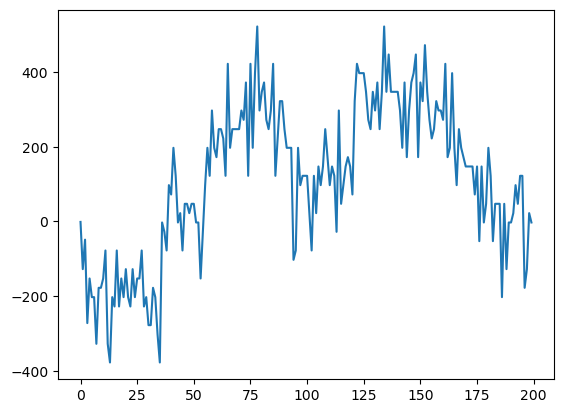

In [93]:
#plt.plot(kelp_data["profit_and_loss"][::10])
import numpy as np
#plt.plot(rainforest_data["profit_and_loss"][::10])
from scipy.signal import savgol_filter

combined_pnl = np.array(kelp_data["profit_and_loss"][::10]) + np.array(rainforest_data["profit_and_loss"][::10])

plt.plot(combined_pnl)

In [94]:
backtester.cash

{'RAINFOREST_RESIN': 499820, 'KELP': 101252}

In [60]:
backtester.current_position

{'RAINFOREST_RESIN': -50, 'KELP': -50}

In [92]:
sum(backtester.pnl.values())

22.0